In [1]:
import numpy as np
import pandas as pd
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn
#from torchsummary import summary
import torchvision

from facenet_pytorch import MTCNN, InceptionResnetV1


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from PIL import Image

import cv2

/Users/maxzhelnin/Conda_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
class GestRecognition(object):

    def __init__(self, 
                 model_classification, path_to_model_class_dict,
                 model_mtcnn, species_label, device='cpu'):
    
        self.model_classification = model_classification
        self.model_classification.load_state_dict(torch.load(path_to_model_class_dict))
        model_classification = model_classification.to(device)
        self.model_mtcnn = model_mtcnn
        self.device = device
        self.species_label = species_label

        self.preprocess = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                             std=[0.229, 0.224, 0.225]),
        ])

    def _image_preprocessing(self, img_file):
        """
            Метод для преобразования изображания к формату, 
            пригодному для подачи в модель
        """

        img = cv2.imread(img_file)
        img_face_recgnt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = Image.open(img_file)
        img_gest_recgnt = self.preprocess(img)

        return img_face_recgnt, img_gest_recgnt
    

    def _face_recognition(self, img_face):
        """
            Метод, который с помощью модели mtcnn определяет
            есть ли лицо на фото и возвращает координаты рамки вокруг него
        """

        boxes, p = self.model_mtcnn.detect(img_face)
        return boxes, p
    
    def _gest_recognition(self, img_gest):

        self.model_classification.eval()
        with torch.no_grad():
            y_pred = self.model_classification(img_gest.unsqueeze(0).to(device))
            probabilities = torch.nn.functional.softmax(y_pred[0], dim=0).to('cpu')
            label_id = int(torch.argmax(probabilities).numpy())

        return label_id
    
    def img_recognition(self, img_file):
        """
            Метод для определения лица на фотографии,
            распознавания жеста и отрисовки
        """

        img_face, img_gest = self._image_preprocessing(img_file)

        boxes, p = self._face_recognition(img_face)
        label_id = self._gest_recognition(img_gest)

        if len(boxes) > 0:
            xmin = int(boxes[0][0])
            xmax = int(boxes[0][2])
            ymin = int(boxes[0][1])
            ymax = int(boxes[0][3])
            img = cv2.rectangle(img_face, (xmin, ymin), (xmax, ymax), color=(255, 0, 0), 
                                thickness=4)
        


        fig, ax1 = plt.subplots(1,1)
        ax1.imshow(img)
        ax1.set_title(f"pred:{self.species_label[label_id]}")
        plt.show()

In [3]:
folder_path = './Hand gestures dataset.v7-complete_v2_416x416.createml/train/'
list_train_img_names = os.listdir(folder_path)

dict_img_codes = {}
name_json_file = ''

for name_str in list_train_img_names:
    #print(name_str.split('.')[-1])
    file_ext = name_str.split('.')[-1]
    if file_ext == 'json':
        name_json_file = name_str
    else:
        list_name_str = name_str.split('.')[:-1]
        img_key = '.'.join(name_str.split('.')[:-1])
        dict_img_codes[img_key] = [img_key + '.jpg',
                                img_key + '.txt']

train_annotation = pd.read_json(folder_path + name_json_file)

train_annotation['label'] = train_annotation['annotations'].apply(lambda x: x[0]['label'])
train_annotation['xc'] = train_annotation['annotations'].apply(lambda x: x[0]['coordinates']['x'])
train_annotation['yc'] = train_annotation['annotations'].apply(lambda x: x[0]['coordinates']['y'])
train_annotation['width'] = train_annotation['annotations'].apply(lambda x: x[0]['coordinates']['width'])
train_annotation['height'] = train_annotation['annotations'].apply(lambda x: x[0]['coordinates']['height'])

train_annotation.drop(columns=['annotations'], inplace=True)

In [4]:
species_labels = sorted(train_annotation['label'].unique())

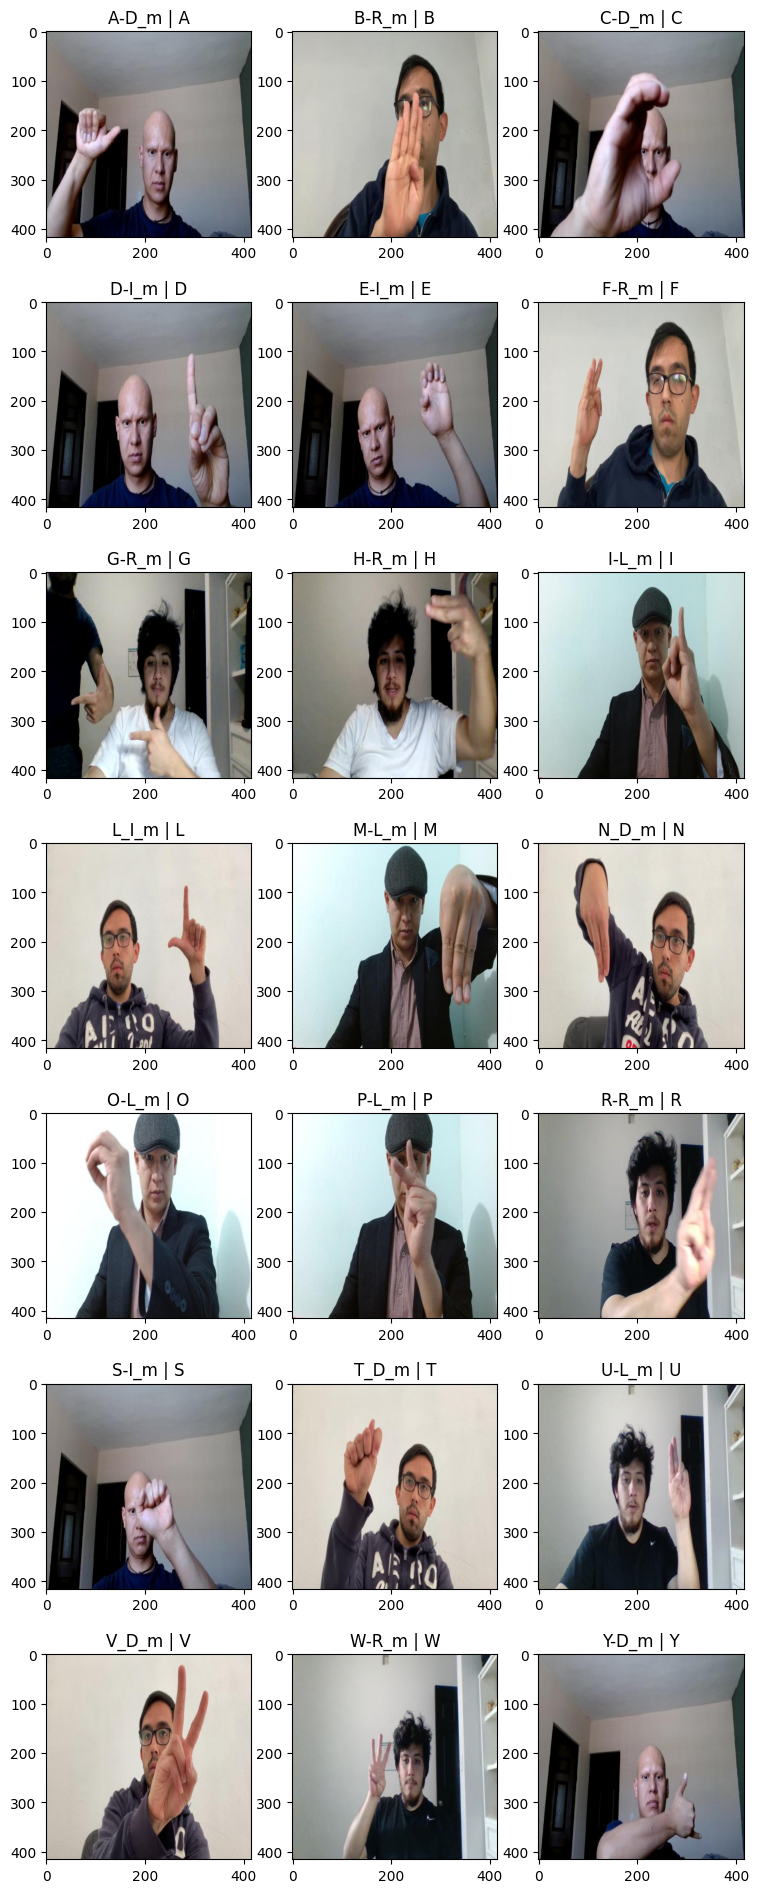

In [5]:
# Код жестов и его обозначение
random_state = 42
folder_path_classification = './Hand gestures dataset.v7-complete_v2_416x416.createml/train/'

fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(9, 24))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    filtr = train_annotation['label'] == species
    img_file = train_annotation.loc[filtr, 'image'].sample(1, random_state=random_state).iloc[0]


    # reads the filepath and returns a numpy array
    img = mpimg.imread(folder_path_classification + img_file)
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_file[0:5]} | {species}")

In [11]:
# Загрузка и инициализация моделей
device = 'cpu'

path_to_my_photo = './my_test_photo_resized/'
path_to_model_class_dict = './models_dict/mobilenet_classification_20epoch.pth'

model_classification = torchvision.models.mobilenet_v2(pretrained=True)
model_classification.classifier = nn.Sequential(
    nn.Linear(1280, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(100, 21, bias=False))  # final dense layer)

model_mtcnn = MTCNN(keep_all=True, device=device)

In [14]:
obj_img_recgnt = GestRecognition(model_classification, path_to_model_class_dict,
                                 model_mtcnn, species_labels)

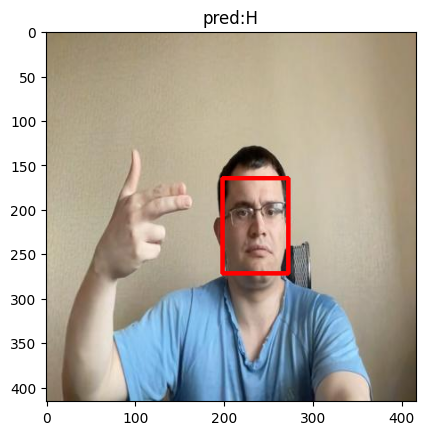

In [17]:
myphoto_img_list = os.listdir(path_to_my_photo)
img_file = path_to_my_photo + myphoto_img_list[1]
obj_img_recgnt.img_recognition(img_file)

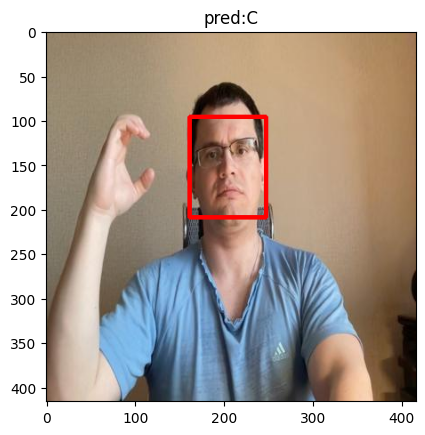

In [19]:
myphoto_img_list = os.listdir(path_to_my_photo)
img_file = path_to_my_photo + myphoto_img_list[2]
obj_img_recgnt.img_recognition(img_file)

Сравнение с изображениями всех жестов, показанными выше, позволяет заключить, <br>
что жесты на фото определены верно.